# Strategy Learner


---

This notebook provides an example of how a StrategyLearner works. This code is also available in the `__main__` function of `StrategyLearner.py`.

## Summary

We choose a stock, an in-sample period and an out-of-sample period. We train a StrategyLearner on the data from the in-sample period and test it on the out-of-sample period. Then we report the performances of the portfolio (only consisting of the stock) and benchmark for both periods. Benchmark is The performance of a portfolio starting with ``$``100,000 cash, investing in 1000 shares of JPM and holding that position.

* In this notebook, we choose the symbol JPM (JPMorgan Chase & Co.)
* The in sample/development period is January 1, 2008 to December 31 2009.
* The out of sample/testing period is January 1, 2010 to December 31 2011.
* Starting cash is ``$``100,000.
* Allowable positions are: 1000 shares long, 1000 shares short, 0 shares.
* There is no limit on leverage.
* Transaction costs: Commission: $0.00, Impact: 0.0.

__*The performance of portfolio is better than benchmark in both periods!*__

## Table of contents:
[1) In-sample performance](#first)

[2) Out-of-sample performance](#second)

Import relevant libraries and modules

In [8]:
2**13

8192

In [7]:
3**8

6561

In [1]:
import datetime as dt

from util import create_df_benchmark
from StrategyLearner import StrategyLearner

import marketsim
import importlib
importlib.reload(marketsim)
from marketsim import compute_portvals_single_symbol, market_simulator
from analysis import get_portfolio_value, get_portfolio_stats, plot_normalized_data

Starting cash, symbol of interest, commission, and impact

In [2]:
start_val = 1000
symbol = "JPM"
commission = 0.00
impact = 0.0
num_shares = 1000

---
## 1) In-sample performance <a class="anchor" id="first"></a>

Show the performances of portfolio and benchmark in the in-sample period

Specify the start and end dates for this period

In [3]:
start_date = dt.datetime(2021, 1, 1)
end_date = dt.datetime(2022, 3, 1)

Get a dataframe of benchmark data. Benchmark is a portfolio starting with ``$``100,000, investing in 1000 shares of symbol and holding that position

In [85]:
from indicators import get_momentum, get_sma_indicator, compute_bollinger_value
from util import  get_feature_file

# datafull = pd.DataFrame()

symbols = os.listdir("../Data/Features")
for _ in symbols:
    symbol = _.split(".")[0]
    # Get adjusted close prices for symbol
    df_features = get_feature_file(symbol)
    prices = df_features['Close']
    df_features.drop(columns=['Close'], inplace=True)

    window = 10
    # Compute rolling mean
    rolling_mean = prices.rolling(window=window, min_periods=1).mean()
    # Compute_rolling_std
    rolling_std = prices.rolling(window=window, min_periods=1).std()
    # Compute momentum
    df_features['momentum'] = get_momentum(prices, window)
    # Compute SMA indicator
    df_features['sma_indicator'] = get_sma_indicator(prices, rolling_mean)
    # Compute Bollinger value
    df_features['bollinger_val'] = compute_bollinger_value(prices, rolling_mean, rolling_std)
    # Create a dataframe with three features
    # df_features = pd.concat([momentum, sma_indicator], axis=1)
    # df_features = pd.concat([df_features, bollinger_val], axis=1)
    df_features['Close'] = prices
    df_features['Returns'] = prices.pct_change()
    # df_features.to_csv("../Data/Features/"+_, index=True)
    
    # df_features['returns'] = prices.pct_change()
    # datafull = pd.concat([datafull, df_features], axis=0)
    break

# df_features.head(10)
# datafull.reset_index(inplace=True)

In [86]:
df_features.head()

,Symbol,alpha1,alpha3,alpha4,alpha5,alpha6,alpha7,alpha8,alpha9,alpha10,alpha11,momentum,sma_indicator,bollinger_val,Returns,Close
Datetime,,,,,,,,,,,,,,,,
2021-01-05,CERN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,78.199996
2021-01-06,CERN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,-0.630005,0.171053,NaN,NaN,0.004012,0.707107,0.008056,78.830001
2021-01-07,CERN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,-0.769997,0.142544,NaN,NaN,0.009170,1.031614,0.009768,79.599998
2021-01-08,CERN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,-0.260002,0.322368,0.890901,NaN,0.009321,0.977279,0.003266,79.860000
2021-01-12,CERN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,0.930000,0.901316,0.791577,NaN,-0.001947,-0.233619,-0.011645,78.930000


In [87]:
# import numpy as np
# import pandas as pd
# thresholds = pd.read_csv("../Data/average.csv", index_col='Datetime',
# parse_dates=True, na_values=['nan'])

# thresholds = thresholds.rolling(window=10, min_periods=1).mean()

df_features[thresholds.keys()] = df_features[thresholds.keys()] - thresholds
for key in thresholds.keys():
    df_features.loc[df_features[key]<0, key] = 0
    df_features.loc[df_features[key]>0, key] = 1
df_features.head()
# df_features = df_features.dropna()
# for i,row in df_features.iterrows():
#     state = np.array(row.drop(['Symbol', 'Close','Returns'])).reshape(1, -1)
#     print(state)
#     break

,Symbol,alpha1,alpha3,alpha4,alpha5,alpha6,alpha7,alpha8,alpha9,alpha10,alpha11,momentum,sma_indicator,bollinger_val,Returns,Close
Datetime,,,,,,,,,,,,,,,,
2021-01-05,CERN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,78.199996
2021-01-06,CERN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,0.0,NaN,NaN,0.0,1.0,0.008056,78.830001
2021-01-07,CERN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,0.0,NaN,NaN,1.0,1.0,0.009768,79.599998
2021-01-08,CERN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,0.0,1.0,NaN,0.0,1.0,0.003266,79.860000
2021-01-12,CERN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,1.0,1.0,NaN,0.0,0.0,-0.011645,78.930000


In [88]:
df_features.dropna(inplace=True)
df_features.shape

(187, 16)

In [92]:
def bi_to_decimal(binary_array):
    return int(''.join(str(x) for x in binary_array), 2)

for i, row in df_features.iterrows():
    state = np.array(row.drop(['Symbol', 'Close','Returns'])).astype(int)

    print(bi_to_decimal(state))
    break

3840


In [2]:
500/3000

0.16666666666666666

In [96]:
str(state)

'[0 1 1 1 1 0 0 0 0 0 0 0 0]'

In [6]:
df_benchmark_trades = create_df_benchmark(symbol, start_date, end_date, 
                                              num_shares)
print (df_benchmark_trades)

            Shares
Date              
2008-01-02    1000
2009-12-31   -1000


In [25]:
df_benchmark_trades = create_df_benchmark(symbol, start_date, end_date, 
                                              num_shares)
print (df_benchmark_trades)

                     Shares
Datetime                   
2021-09-01 13:30:00    1000
2021-12-30 21:00:00   -1000


In [12]:
import pandas as pd
import os
# from util import get_data
def symbol_to_path(symbol, base_dir=None):
    """Return CSV file path given ticker symbol."""
    if base_dir is None:
        base_dir = os.environ.get("MARKET_DATA_DIR", '../Data/')
    return os.path.join(base_dir, "{}.csv".format(str(symbol)))


,JPM


In [13]:

df = pd.DataFrame()

s = symbol
df_temp = pd.read_csv(symbol_to_path(s), index_col='Datetime',
        parse_dates=True, usecols=['Datetime', 'Close'], na_values=['nan'])
df_temp = df_temp.rename(columns={'Close': s})
df = df.join(df_temp)
if s == 'SPY':  # drop dates SPY did not trade
    df = df.dropna(subset=["SPY"])

# test = get_data(, addSPY=False)#.dropna()
df.head()

,JPM


In [14]:
df_temp

,JPM
Datetime,
2021-01-04 14:30:00,127.660003
2021-01-04 14:35:00,127.610000
2021-01-04 14:40:00,127.561599
2021-01-04 14:45:00,127.559997
2021-01-04 14:50:00,127.319999
...,...
2022-02-28 20:40:00,141.000000
2022-02-28 20:45:00,141.425003
2022-02-28 20:50:00,141.229995


Create an instance of StrategyLearner and retrieve a trades dataframe via test_policy

/home1/zydong/miniconda3/envs/anaconda/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


1 -0.23691541279996076
2 0.222215870213619
3 -0.5532588578277347
4 -0.07996974262823894
5 0.8945293748903203
6 0.19095167055801993
7 0.3183303773255939
8 1.2987755263953749
9 -0.35599214692160247
10 0.6201346989977815
11 0.6306691162333258
12 1.2768079043389906
13 0.5760665860429864
14 1.2406806780977073
15 1.1728572221819054
16 1.415042685657908
17 1.2379838752872345
18 0.9585216092470098
19 1.8348893234141277
20 1.3812693038751003
21 1.5276137662564544
22 1.0564109967557471
23 1.0914109612964875
24 1.5696818755489048
25 2.2178981623224785
26 1.5000422634410768
27 2.0684312932736235
28 1.2493453198476419
29 1.6090558137231512
30 1.245606790064023
31 1.5835302827121456
32 1.8381053912542658
33 2.1941278786447627
34 0.14679400509040155
35 0.9261584017860144
36 0.5671200719895403
37 1.7857997253759734
38 1.4478574969643936
39 1.3977531106005963
40 1.1652219726386315
41 0.8556186475644803
42 1.071436508073811
43 2.131723214748273
44 1.9763156592201128
45 2.165658300200306
46 2.32311710811

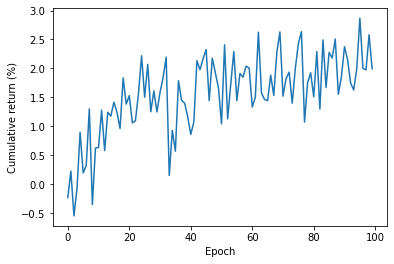

In [4]:
# Train and test a StrategyLearner
# Set verbose to True will print out and plot the cumulative return for each training epoch

import StrategyLearner
importlib.reload(StrategyLearner)
from StrategyLearner import StrategyLearner

stl = StrategyLearner(num_shares=num_shares, impact=impact, 
                      commission=commission, verbose=True, num_actions=3)
stl.add_evidence(start_val=start_val)

In [14]:
stl.q_learner.Q

array([[-0.00080857,  0.00780608,  0.00295597],
       [-0.00226468,  0.00174283,  0.01960489],
       [ 0.00407096,  0.0122709 ,  0.        ],
       ...,
       [ 0.010524  ,  0.        ,  0.        ],
       [-0.00027966,  0.00637425,  0.        ],
       [ 0.01906739,  0.00123392,  0.00021646]])

In [8]:
# import StrategyLearner
# importlib.reload(StrategyLearner)
# from StrategyLearner import StrategyLearner
# stl = StrategyLearner(num_shares=num_shares, impact=impact, 
#                       commission=commission, verbose=True, num_actions=3)
# stl.q_learner.Q = pickle.load(open("Q_table.pkl", 'rb'))
# stl.q_learner.rar = 0
# stl.add_evidence(start_val=start_val)

# stl = pickle.load(open("Q_table.pkl", 'rb'))
# print(stl.q_learner.Q)
symbol = "PM"
start_date = dt.datetime(2021, 9, 1)
end_date = dt.datetime(2021, 12, 31)

df_trades, prices = stl.test_policy(symbol=symbol, start_date=start_date, end_date=end_date)
print (df_trades)

Cummulative Return  1.413002999999994
Datetime
2021-09-01       0.0
2021-09-02       0.0
2021-09-03       0.0
2021-09-08       0.0
2021-09-09       0.0
               ...  
2021-12-23   -1000.0
2021-12-28       0.0
2021-12-29    1000.0
2021-12-30       0.0
2021-12-31       0.0
Length: 67, dtype: float64


/home1/zydong/miniconda3/envs/anaconda/lib/python3.9/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [10]:
import pandas as pd
import numpy as np

In [11]:
df_benchmark_trades = pd.Series(np.zeros(len(prices)), index=prices.index)
df_benchmark_trades.iloc[0] = num_shares
df_benchmark_trades.iloc[-1] = -num_shares
df_benchmark_trades

Datetime
2021-09-01    1000.0
2021-09-02       0.0
2021-09-03       0.0
2021-09-08       0.0
2021-09-09       0.0
               ...  
2021-12-23       0.0
2021-12-28       0.0
2021-12-29       0.0
2021-12-30       0.0
2021-12-31   -1000.0
Length: 67, dtype: float64

In [5]:
2**20

1048576

Performances during training period for PM
Date Range: 2021-09-01 00:00:00 to 2021-12-31 00:00:00
Sharpe Ratio of Portfolio: -0.35609718434286697
Sharpe Ratio of Benchmark : 1.8768661429958353

Cumulative Return of Portfolio: 14.130029999999941
Cumulative Return of Benchmark : -8.559996999999989

Standard Deviation of Portfolio: 10.90023513754688
Standard Deviation of Benchmark : 6.172261426717834

Average Daily Return of Portfolio: -0.24451422833550326
Average Daily Return of Benchmark : 0.7297554415563802

Final Portfolio Value: 15130.02999999994
Final Benchmark Value: -7559.9969999999885


/home1/zydong/miniconda3/envs/anaconda/lib/python3.9/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


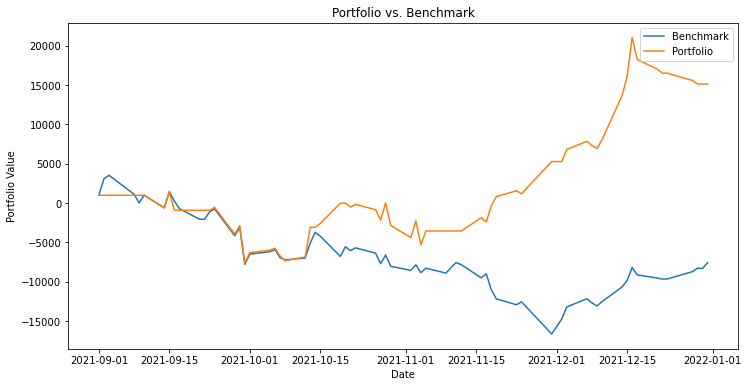

In [12]:

# Retrieve performance stats via a market simulator
print ("Performances during training period for {}".format(symbol))
print ("Date Range: {} to {}".format(start_date, end_date))
market_simulator(df_trades, df_benchmark_trades, prices=prices, 
                    start_val=start_val, commission=commission, impact=impact)

In [55]:
"""Q table"""
stl.q_learner.Q

array([[ 0.00701002,  0.01533277, -0.02469315],
       [ 0.01005247,  0.00541853,  0.        ],
       [ 0.00712302, -0.00022469, -0.00370593],
       ...,
       [ 0.00576021,  0.        ,  0.        ],
       [ 0.00291273,  0.        ,  0.02525839],
       [ 0.00473769,  0.        ,  0.        ]])

In [13]:
import pickle

with open('stl.pkl', 'wb') as output:
    pickle.dump(stl.q_learner.Q, output, pickle.HIGHEST_PROTOCOL)

1 -0.5893999999999999
2 -0.0928
3 0.3097000000000001
4 0.2811999999999999
5 0.3621000000000001
6 0.3447
7 0.3447
8 0.3447
9 0.3447
10 0.3447
11 0.3447
12 0.3447
13 0.3447
14 0.3447
15 0.3447
16 0.3447
17 0.3447
18 0.3447
19 0.3447
20 0.3447
21 0.3447


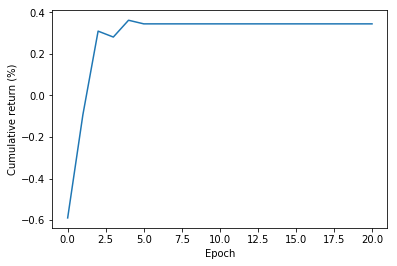

            Shares
Date              
2008-01-16   -1000
2008-01-22    1000
2008-01-30    1000
2008-01-31   -1000
2008-02-06   -1000
2008-02-25    1000
2008-02-28   -1000
2008-03-17    1000
2008-03-25    1000
2008-03-26   -1000
2008-04-04   -1000
2008-04-21    1000
2008-04-23   -1000
2008-04-24    1000
2008-05-08   -1000
2008-05-13    1000
2008-05-14   -1000
2008-06-23    1000
2008-06-24   -1000
2008-07-16    1000
2008-07-23    1000
2008-07-24   -1000
2008-07-31   -1000
2008-08-01    1000
2008-08-11   -1000
2008-08-26    1000
2008-09-22   -1000
2008-09-23    1000
2008-10-02    1000
2008-10-03   -1000
...            ...
2009-04-16    1000
2009-04-17   -1000
2009-04-27   -1000
2009-04-28    1000
2009-04-30   -1000
2009-05-01    1000
2009-05-22   -1000
2009-05-27    1000
2009-06-02   -1000
2009-06-04    1000
2009-06-09   -1000
2009-06-17    1000
2009-06-18   -1000
2009-06-19    1000
2009-06-22   -1000
2009-06-29    1000
2009-07-02   -1000
2009-07-09    1000
2009-09-01   -1000
2009-09-10  

In [9]:
# Train and test a StrategyLearner
# Set verbose to True will print out and plot the cumulative return for each training epoch
stl = StrategyLearner(num_shares=num_shares, impact=impact, 
                      commission=commission, verbose=True,
                      num_states=3000, num_actions=3)
stl.add_evidence(symbol=symbol, start_val=start_val, 
                 start_date=start_date, end_date=end_date)
df_trades = stl.test_policy(symbol=symbol, start_date=start_date,
                            end_date=end_date)
print (df_trades)

Retrieve performance stats via a market simulator

In [13]:
# Retrieve performance stats via a market simulator
print ("Performances during training period for {}".format(symbol))
print ("Date Range: {} to {}".format(start_date, end_date))
market_simulator(df_trades, df_benchmark_trades, symbol=symbol, 
                 start_val=start_val, commission=commission, impact=impact)

Performances during training period for JPM
Date Range: 2021-01-01 00:00:00 to 2022-03-01 00:00:00


NameError: name 'df_benchmark_trades' is not defined

Performances during training period for JPM
Date Range: 2008-01-01 00:00:00 to 2009-12-31 00:00:00
Sharpe Ratio of Portfolio: 1.12511257551527
Sharpe Ratio of Benchmark : 0.15691840642403027

Cumulative Return of Portfolio: 0.3447
Cumulative Return of Benchmark : 0.012299999999999978

Standard Deviation of Portfolio: 0.009055938131234257
Standard Deviation of Benchmark : 0.017004366271213767

Average Daily Return of Portfolio: 0.0006418435116413186
Average Daily Return of Benchmark : 0.00016808697819094035

Final Portfolio Value: 134470.0
Final Benchmark Value: 101230.0


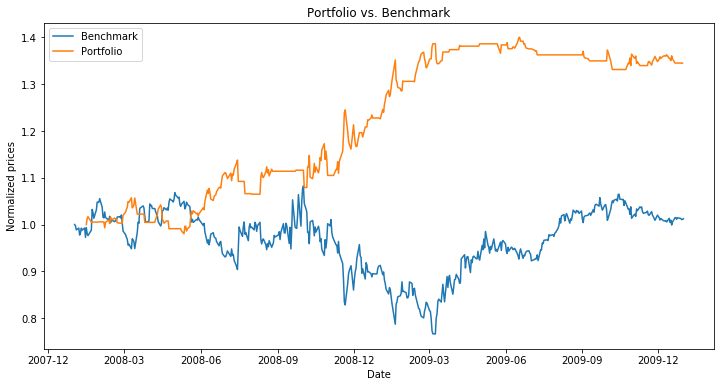

In [12]:
# Retrieve performance stats via a market simulator
print ("Performances during training period for {}".format(symbol))
print ("Date Range: {} to {}".format(start_date, end_date))
market_simulator(df_trades, df_benchmark_trades, symbol=symbol, 
                 start_val=start_val, commission=commission, impact=impact)

---
## 2) Out-of-sample performance <a class="anchor" id="second"></a>

Show the performances of portfolio and benchmark in the out-of-sample period

Specify the start and end dates for this period

In [13]:
start_date = dt.datetime(2010, 1, 1)
end_date = dt.datetime(2011, 12, 31)

Get a dataframe of benchmark data. Benchmark is a portfolio starting with ``$``100,000, investing in 1000 shares of symbol and holding that position.

In [14]:
df_benchmark_trades = create_df_benchmark(symbol, start_date, end_date, 
                                          num_shares)

Use the same StrategyLearner trained above and retrieve a trades dataframe via test_policy

In [15]:
df_trades = stl.test_policy(symbol=symbol, start_date=start_date, 
                            end_date=end_date)
print (df_trades)

            Shares
Date              
2010-01-19   -1000
2010-02-09    1000
2010-02-10   -1000
2010-02-18    1000
2010-04-05   -1000
2010-04-07    1000
2010-04-09   -1000
2010-04-14    1000
2010-04-20   -1000
2010-06-02    1000
2010-06-03   -1000
2010-06-17    1000
2010-06-30   -1000
2010-07-13    1000
2010-07-14    1000
2010-07-15   -1000
2010-07-21   -1000
2010-07-23    1000
2010-07-27   -1000
2010-07-30    1000
2010-08-06   -1000
2010-08-27    1000
2010-08-31   -1000
2010-09-02    1000
2010-09-08    1000
2010-09-09   -1000
2010-09-14    1000
2010-09-15   -1000
2010-09-24   -1000
2010-10-07    1000
...            ...
2011-08-03   -1000
2011-08-24    1000
2011-08-29   -1000
2011-08-30    1000
2011-08-31   -1000
2011-09-01    1000
2011-09-02   -1000
2011-09-26    1000
2011-09-27   -1000
2011-10-05    1000
2011-10-10   -1000
2011-10-12    1000
2011-10-13   -1000
2011-10-18    1000
2011-10-20   -1000
2011-10-21    1000
2011-10-25   -1000
2011-10-27    1000
2011-10-31   -1000
2011-12-02  

Retrieve performance stats via a market simulator


Performances during testing period for JPM
Date Range: 2010-01-01 00:00:00 to 2011-12-31 00:00:00
Sharpe Ratio of Portfolio: 0.3228723006593053
Sharpe Ratio of Benchmark : -0.2568129607376273

Cumulative Return of Portfolio: 0.05620000000000003
Cumulative Return of Benchmark : -0.08340000000000003

Standard Deviation of Portfolio: 0.0065329616932926346
Standard Deviation of Benchmark : 0.008481007498803986

Average Daily Return of Portfolio: 0.00013287418985118472
Average Daily Return of Benchmark : -0.00013720316019481813

Final Portfolio Value: 105620.0
Final Benchmark Value: 91660.0


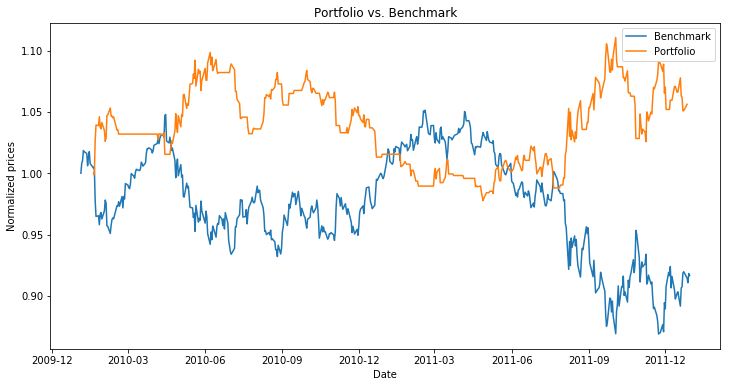

In [16]:
print ("\nPerformances during testing period for {}".format(symbol))
print ("Date Range: {} to {}".format(start_date, end_date))
market_simulator(df_trades, df_benchmark_trades, symbol=symbol, 
                 start_val=start_val, commission=commission, impact=impact)